<a href="https://colab.research.google.com/github/merhaines/AIT-Deep-Learning/blob/main/DL_Assessment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
raven_url = "https://www.gutenberg.org/files/17192/17192-8.txt"
gatsby_url = "https://www.gutenberg.org/files/64317/64317-0.txt"

raven_text = requests.get(raven_url).text
gatsby_text = requests.get(gatsby_url).text

In [3]:
# Sift through the texts
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()
    return text

raven_text = clean_text(raven_text)
gatsby_text = clean_text(gatsby_text)

# Combine the two texts
combined_texts = [raven_text, gatsby_text]
# 0 = raven, 1 = gatsby
labels = [0, 1]  

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(combined_texts)
alphabet_length = len(tokenizer.word_index)

sequences = tokenizer.texts_to_sequences(combined_texts)

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

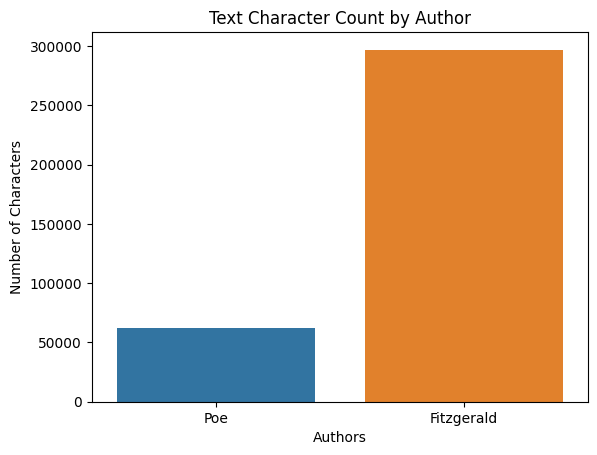

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count characters in each text
num_chars_raven = len(raven_text)
num_chars_gatsby = len(gatsby_text)

# Display results on Seaborn countplot
authors = ['Poe', 'Fitzgerald']
char_counts = [num_chars_raven, num_chars_gatsby]

sns.barplot(x=authors, y=char_counts)
plt.ylabel('Number of Characters')
plt.xlabel('Authors')
plt.title('Text Character Count by Author')
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [5]:
def sliding_window(text, label, sequence_length):
    num_sequences = len(text) - sequence_length + 1
    X = np.zeros((num_sequences, sequence_length))
    y = np.zeros((num_sequences, 1))

    for i in range(num_sequences):
        X[i, :] = text[i:i + sequence_length]
        y[i] = label

    return X, y

# Generates labels for both authors
sequence_length = 60

X_raven, y_raven = sliding_window(sequences[0], labels[0], sequence_length)
X_gatsby, y_gatsby = sliding_window(sequences[1], labels[1], sequence_length)

X = np.concatenate([X_raven, X_gatsby], axis=0)
y = np.concatenate([y_raven, y_gatsby], axis=0)

## Data splitting
Split the data into train, validate and test sets. Make 

In [6]:
X_tokenized_train, X_tokenized_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_tokenized_val, X_tokenized_test, y_val, y_test = train_test_split(X_tokenized_temp, y_temp, test_size=0.5, random_state=42)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [7]:
def build_lstm_model(sequence_length, alphabet_length):
    model = Sequential()
    model.add(Embedding(alphabet_length + 1, 32, input_length=sequence_length))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_lstm_model(sequence_length, alphabet_length)

## Model training
Train the model and apply early stopping.

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_tokenized_train, y_train,
                    validation_data=(X_tokenized_val, y_val),
                    epochs=10, batch_size=512,
                    callbacks=[early_stopping])

Epoch 1/10
491/491 [==============================] - 237s 474ms/step - loss: 0.1942 - accuracy: 0.9064 - val_loss: 0.1853 - val_accuracy: 0.9070
Epoch 2/10
491/491 [==============================] - 231s 471ms/step - loss: 0.1878 - accuracy: 0.9080 - val_loss: 0.1770 - val_accuracy: 0.9094
Epoch 3/10
491/491 [==============================] - 230s 469ms/step - loss: 0.1811 - accuracy: 0.9108 - val_loss: 0.1658 - val_accuracy: 0.9160
Epoch 4/10
491/491 [==============================] - 239s 486ms/step - loss: 0.1744 - accuracy: 0.9124 - val_loss: 0.1586 - val_accuracy: 0.9179
Epoch 5/10
491/491 [==============================] - 228s 465ms/step - loss: 0.1669 - accuracy: 0.9161 - val_loss: 0.1487 - val_accuracy: 0.9219
Epoch 6/10
491/491 [==============================] - 229s 467ms/step - loss: 0.1600 - accuracy: 0.9178 - val_loss: 0.1373 - val_accuracy: 0.9274
Epoch 7/10
491/491 [==============================] - 228s 465ms/step - loss: 0.1519 - accuracy: 0.9215 - val_loss: 0.1297 -

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [10]:
loss, accuracy = model.evaluate(X_tokenized_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

1682/1682 [==============================] - 21s 13ms/step - loss: 0.1071 - accuracy: 0.9396
Test loss: 0.1071, Test accuracy: 0.9396


## Confusion matrix
Calculate and display the confusion matrix.

1682/1682 [==============================] - 27s 16ms/step


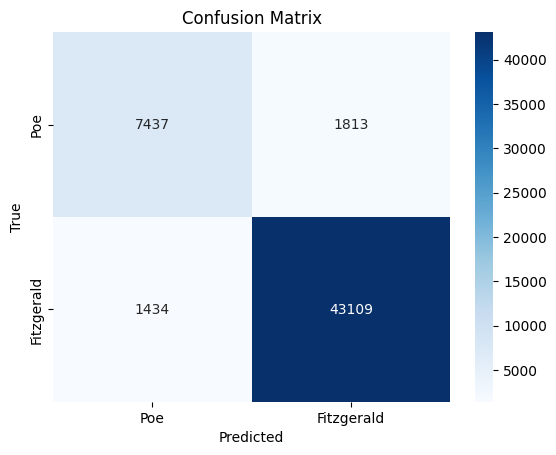

In [11]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred_proba = model.predict(X_tokenized_test)
y_pred = np.round(y_pred_proba).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=authors, yticklabels=authors)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()